# Apresentação ✒️

Notebook destinado ao estudo da recuperação de informação de banco de dados vetorial. Apesar da recuperação ser realizada por meio da semelhança vetorial entre o elemento de consulta em relação aos dados que estão armazenados, nem sempre ela consegue retornar informações relevantes.

Em virtude disso, esse notebook se debruça ao estudo de técnicas que buscam ultrapassar esse obstáculo, sendo capaz de prover ao usuário respostas relevantes com base em sua consulta, sem trazer termos que, ainda que sejam similares do ponto de vista vetorial, pouco contribuem para o que o usuário havia consultado.

Para isso será utilizado o framework chroma, que cria banco de dados vetorial, juntamente com o framework langchain.

## Biblioteca 📚

In [1]:
!pip install langchain langchain__community langchain_google_genai chromadb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install google-generativeai -q

In [3]:
!pip install pypdf -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 4.1 MB/s eta 0:00:00


In [4]:
!pip install sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.3 MB/s eta 0:00:00


In [5]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00


In [6]:
import os
import umap.umap_ as umap
import numpy as np
import chromadb
import google.generativeai as genai

from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain import PromptTemplate
from langchain.chains import LLMChain

from pypdf import PdfReader

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from tqdm import tqdm

## Definindo as variáveis de ambiente



In [7]:
os.environ["GOOGLE_API_KEY"] = ""

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

## Definindo o modelo de LLM de uso

In [8]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-pro-latest",
    temperature=0.2
)

## Carregando os dados 💾

In [9]:
file_path = "/content/microsoft_annual_report_2022.pdf"
reader = PdfReader(file_path)


pdf_text = [p.extract_text() for p in reader.pages]

# Filtrando strings vazias para que apenas retornem texto.

pdf_text = [text for text in pdf_text if text]

In [10]:
len(pdf_text)

92

In [11]:
# Visualizando o texto extraído.

pdf_text[0:2]

['   \n',
 '1 Dear shareholders, colleagues, customers, and partners:  \nWe are living through a period of historic economic, societal, and geopolitical change. The world in 2022 looks nothing like \nthe world in 2019. As I write this, inflation is at a 40 -year high, supply chains are stretched, and the war in Ukraine is \nongoing. At the same time, we are entering a technological era with the potential to power awesome advancements \nacross every sector of our economy and society. As the world’s largest software company, this places us at a historic \nintersection of opportunity and responsibility to the world around us.  \nOur mission to empower every person and every organization on the planet to achieve more has never been more \nurgent or more necessary. For all the uncertainty in the world, one thing is clear: People and organizations in every \nindustry are increasingly looking to digital technology to overcome today’s challenges and emerge stronger. And no \ncompany is better 

## Dividindo o texto

A técnica de divisão de texto visa otimizar o processo de consulta, de modo a reduzir o ruído que o termo a ser consultado poderia sofrer em relação ao conjunto total de dados presentes. Desse modo, segmentando parte a parte, torna-se mais fácil para extrair a informação relevante com base na similaridade entre os vetores.

In [12]:
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1200,
    chunk_overlap = 200,
    length_function = len,
    separators = ["\n\n", "\n",".", " ", "", "?"],
)

In [13]:
text_splitted = recursive_splitter.split_text('\n\n'.join(pdf_text))

In [14]:
len(text_splitted)

313

In [15]:
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=256,
    chunk_overlap=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
token_split_text = []

for text in text_splitted:
  token_split_text += token_splitter.split_text(text)

In [17]:
len(token_split_text)

334

In [18]:
print(f"Tamanho do texto orginal : {len(pdf_text)}")
print(f"Tamanho do texto na primeira divisão : {len(text_splitted)}")
print(f"Tamanho do texto dividido na segunda divisão : {len(token_split_text)}")

Tamanho do texto orginal : 92
Tamanho do texto na primeira divisão : 313
Tamanho do texto dividido na segunda divisão : 334


## Instanciando o modelo de embedding adotado

O modelo de embedding é responsável por transformar termos de linguagem natural para a sua representação vetorial, tornando possível o armazenamento de informação de algo que anteriormente era texto em um banco de dados vetorial.

In [19]:
embedding = SentenceTransformerEmbeddingFunction()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Criando o banco de dados vetorial

In [20]:
# Criando o objeto client que me permitirá interagir
# com o ChromaDB, para criar o banco de dados vetorial.

chroma_client = chromadb.Client()

In [21]:
# Criando o banco de dados vetorial.

chroma_collection = chroma_client.create_collection(name="ai_agents", embedding_function=embedding)

In [22]:
# Gerando uma lista de identificação para cada porção
# presente no meu banco de dados vetorial.

ids = [str(i) for i in range(len(token_split_text))]

In [23]:
# Uma vez criado o banco de dados vetorial, agora passo
# os documentos, junto de sua identificação a ele.

chroma_collection.add(ids=ids, documents= token_split_text)

In [24]:
# Verificando a quantidade de itens presentes no banco de dados vetorial :

chroma_collection.count()

334

## Realizando a consulta

In [25]:
query = "What is about this article ?"

result = chroma_collection.query(query_texts=[query], n_results=3)


In [26]:
retrieved_documents = result["documents"]

In [43]:
retrieved_documents

[['the opportunity to apply technology to make a real difference for every customer, community, and country has never been greater. and i truly believe if we continue to live our mission, embrace our responsibility, and grasp that opportunity, there is no limit to what we can achieve for the world in the year ahead and beyond. satya nadella chairman and chief executive officer october 24, 2022',
  'safeguarding electoral processes is as salient as ever in today ’ s geopolitical climate. our accountguard nation - state threat notification service protects more than 4 million accounts of election officials, human rights organizations, journalists, and other organizations. our efforts to preserve and protect journalism in the united states and mexico have been extended globally through new partnerships with the thomson reuters foundation, report for the world, and others. this year, we responded to six humanitarian emergencies in five countries through donations, technology, services, and

## Realizando a consulta com a LLM

In [27]:
def rag(query, retrieved_documents, model = llm):

  information = '\n\n'.join(retrieved_documents[0])

  prompt_template = PromptTemplate(
      input_variables=["query", "information"],
      template="""
      You are a helpful, experienced information systems professional. You need to respond accurately and elucidatively to the user's query regarding Microsoft's annual report. You will be presented with the user's question and the relevant parts of the annual report. Answer the user's question using only the information presented to you.

      Question: {query}
      Information : {information}
      """
      )

  chain = LLMChain(llm=model, prompt=prompt_template)
  response = chain.run(query=query, information=information)

  return response

In [28]:
output = rag(query, retrieved_documents)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [29]:
output

'This excerpt from Microsoft\'s annual report, penned by CEO Satya Nadella, emphasizes the significant opportunity to leverage technology for positive global impact. It highlights Microsoft\'s commitment to:\n\n* **Using technology for good:** This includes safeguarding elections, supporting journalism, and aiding humanitarian efforts through initiatives like "AccountGuard" and "AI for Humanitarian Action."\n* **Promoting inclusive economic growth:** Microsoft aims to make technology accessible and provide digital skills training to ensure everyone benefits from technological advancements. \n\nEssentially, the message is that Microsoft believes in technology\'s power to drive positive change and is actively working towards a more inclusive, equitable, and sustainable future. \n'

## Identificando quando somente a pesquisa por semelhança entre vetores falha

Uma vez realizado a técnica de RAG padrão, objetiva-se agora visualizar a sua eficiência na recuperação de informação que não apenas seja semelhante do ponto de vista vetorial, mas relevante à consulta, isto é, que consiga respondê-la de forma eficiente.

Para isso, irei dispor da visualização gráfica, para visualizar o banco de dados vetorial e, posteriormente, quais elementos estão sendo recuperados e se são apenas aqueles que são relevantes ou similares vetorialmente.

In [30]:
# Para realizar a visualização do banco de dados vetorial, tendo em vista
# que ele é multidimensional, terei que realizar uma transformação dimensional
# para que ele caiba em duas dimensões para facilitar a compreensão.

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [31]:
def project_embeddings(embeddings, umap_transform):

    umap_embeddings = np.empty((len(embeddings),2))

    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])

    return umap_embeddings

In [32]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 334/334 [06:34<00:00,  1.18s/it]


(-1.5580700933933258, 8.197751313447952, 3.004087138175964, 8.215628457069396)

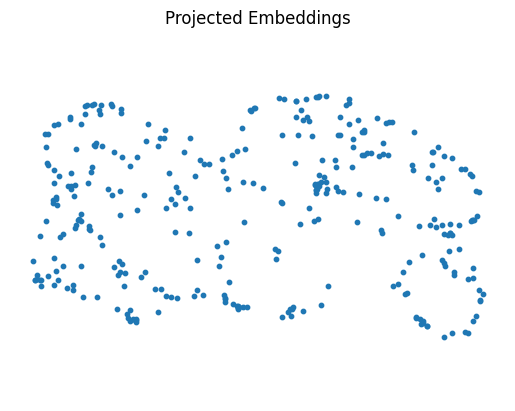

In [33]:
# Visualizando o banco de dados vetorial de uso em 2d.

# Nesse espaço, há armazenado os itens referentes ao artigo carregado,
# lido e dividido.

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [34]:
# Visualizando os elementos trazidos durante o momento da consulta.

query = "What is the strategy around artificial intelligence (AI) ?"

results = chroma_collection.query(query_texts=[query], n_results=5, include=['documents',
                                                                             'embeddings'])

retrieved_documents = results["documents"][0]

In [35]:
# Visualizando o documento recuperado.

retrieved_documents[0]

'while simplifying security and management. from infrastructure and data, to business applications and collaboration, we provide unique, differentiated value to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial environments, feel a greater sense of presence in the new world of hybrid work, and create custom immersive worlds to enable new opportunities for connection and experimentation. what we offer founded in 1975, we develop and support software, services, devices, and solutions that deliver new value for customers and help people and businesses 

In [36]:
query_embeddings = embedding(query)[0]
retrieved_embeddings = results["embeddings"][0]

In [37]:
projected_query_embedding = project_embeddings([query_embeddings], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


(-1.5580700933933258, 8.197751313447952, 3.004087138175964, 8.215628457069396)

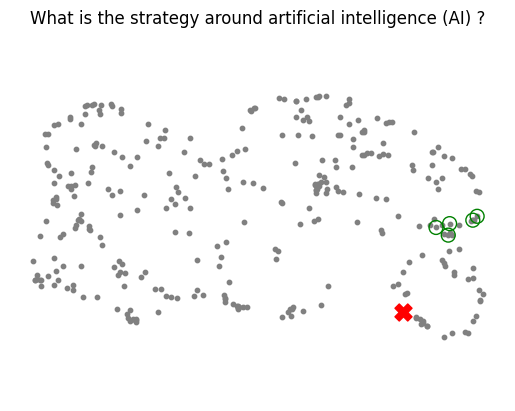

In [38]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

No gráfico acima é possível observar que nem sempre o termo efetivamente consultado é aquele que poderia prover a resposta mais relevante. Nele, os vetores que poderiam trazer as respostas relevantes à consulta são marcados em verde, equanto que o vetor selecionado é marcado em vermelho.

Nota-se que ele dista bastante dos vetores mais relevantes, o que significa em termos gerais que a resposta informada a consulta do usuário não será relevante, mesmo que possa ser vetorialmente similar.

Com base nisso, surge algumas técnicas que visam prover uma melhor recuperação da informação, a fim de retornar informações que sejam relevantes para responder as consultas do usuário e que serão trazidas a seguir.

## Query Expansion

Uma das técnicas utilizadas para prover retorno de informação relevante às consultas do usuários é conhecida como Query Expansion, a qual apresenta duas possíveis abordagens : respostas hipotéticas ou sugestões de tipos de consulta realizadas, ambas, por um modelo de LLM.

No caso das respostas hipotéticas, o que se faz é informar a query ao modelo de LLM e requisitar a ele que com base nisso gere uma possível resposta. Uma vez a resposta ter sido gerada, combina-se ela com a query e os envia como consulta, em conjunto, ao banco de dados vetorial. A partir dessa combinação, delimita-se melhor o campo de busca, como forma que o elemento a ser consultado será mais aderente aos elementos que possuem maior relevância.

No caso das sugestões de tipos de consulta, o processo final é similar, mas o início é diferente. Ao invés de requisitar uma possível resposta ao modelo com base na query, por meio dela busca-se encontrar possível consultas que poderiam melhor delimitar o campo de busca, tornando-as mais precisas quando comparadas com a consulta original que poderia ser vaga.

Desse modo, independente da abordagem adotada, essa técnica reside justamente numa expansão da consulta, como o nome sugere, a partir da qual busca-se delimitar melhor o campo de busca, durante o processo de recuperação, como forma de retornar não apenas conteúdos que sejam semelhantes do ponto de vista vetorial, mas também relevantes.

### Expansion com respostas hipotéticas

In [39]:
def hypothetical_answer(query, model = llm):

  template = PromptTemplate(
      input_variables=["query"],
      template="""
      You are a helpful, experienced information systems professional.
      Provide an example answer to the given question, that might be found
      in a document like an annual report.

      Question : {query}

      Helpful Answer : """  )

  chain = LLMChain(llm=model, prompt=template)
  response = chain.run(query=query)

  return response

In [40]:
original_query = "What is the strategy around artificial intelligence (AI) ?"
hypothetical_answer_output = hypothetical_answer(original_query)

In [104]:
# Visualizando a resposta hipotética.

hypothetical_answer_output

'##  Our Artificial Intelligence Strategy \n\nWe recognize the transformative potential of artificial intelligence (AI) to enhance our operations, improve decision-making, and deliver exceptional customer experiences. Our AI strategy is built on three core pillars:\n\n**1.  Enhancing Operational Efficiency:** We are actively integrating AI and machine learning algorithms into our core operational processes. This includes:\n\n*   **Automating routine tasks:**  Leveraging AI to automate repetitive tasks, freeing up our workforce to focus on higher-value activities that require creativity and complex problem-solving. \n*   **Predictive maintenance:** Implementing AI-powered predictive models to anticipate and address potential equipment failures, minimizing downtime and optimizing maintenance schedules. \n*   **Optimizing resource allocation:** Utilizing AI algorithms to analyze data and optimize resource allocation across the organization, improving efficiency and reducing costs.\n\n**2.

In [41]:
joint_query = f"{original_query} {hypothetical_answer_output}"

joint_query

'What is the strategy around artificial intelligence (AI) ? ##  Our Artificial Intelligence Strategy \n\nWe recognize the transformative potential of artificial intelligence (AI) across all facets of our business. Our AI strategy is built on three core pillars: \n\n**1. Enhance Operations and Efficiency:** We are actively integrating AI and machine learning algorithms to optimize internal processes, automate repetitive tasks, and improve operational efficiency. This includes leveraging AI for:\n\n* **Predictive Maintenance:** Anticipating and addressing potential equipment failures to minimize downtime and maintenance costs.\n* **Supply Chain Optimization:** Forecasting demand, optimizing inventory levels, and streamlining logistics for improved efficiency and cost savings.\n* **Fraud Detection and Prevention:** Implementing AI-powered systems to identify and mitigate potential fraudulent activities, enhancing security and trust.\n\n**2. Drive Innovation and Growth:** We are committed 

In [42]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

In [43]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding([original_query])
augmented_query_embedding = embedding([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


(-1.5580700933933258, 8.197751313447952, 3.004087138175964, 8.215628457069396)

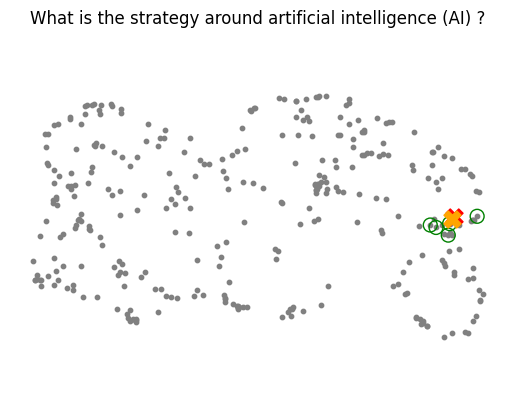

In [44]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Expansion com mais querys

In [46]:
def argument_multiple_query(query, model = llm):

  template = PromptTemplate(
      input_variables=["query"],
      template="""
      You are a helpful, experienced information systems professional.
      Suggest up to five additional related questions to help them find the information they need, for the provided question. "
      Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
      Make sure they are complete questions, and that they are related to the original question."
      Output one question per line. Do not number the questions."

      Question : {query}

      Helpful Answer : """  )

  chain = LLMChain(llm=model, prompt=template)
  response = chain.run(query=query)

  return response

In [47]:
original_query = "What is the strategy around artificial intelligence (AI) ?"
argumented_multiple_query_output = argument_multiple_query(original_query)

In [49]:
queries = f'{original_query}  {argumented_multiple_query_output}'
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

In [50]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding([original_query])
augmented_query_embedding = embedding([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


(-1.5580700933933258, 8.197751313447952, 3.004087138175964, 8.215628457069396)

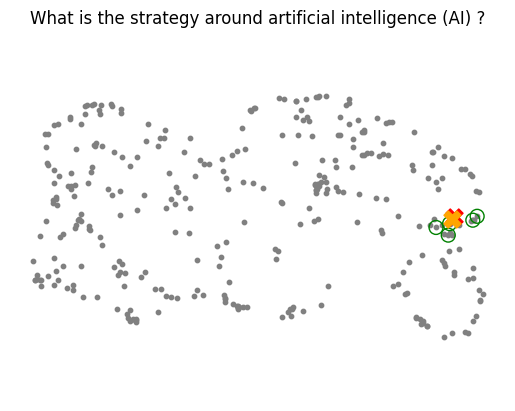

In [51]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')